In [14]:

# LSTM + CNN
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from pyproj import Transformer

import binascii
from shapely import wkb
import pyproj

def convert_wkb_to_coordinates(wkb_string):
    
    # 0단계 :Check if the value is a float
    if isinstance(wkb_string, float):
        return None, None
    
    # 1단계: 16진수 문자열을 이진 형식으로 디코딩
    binary_string = binascii.unhexlify(wkb_string)

    # 2단계: 이진 형식 파싱 
    geometry = wkb.loads(binary_string)

    # 3단계: 좌표를 위도와 경도로 변환
    if geometry and hasattr(geometry, 'wkt'):
        # Well-Known Text (WKT) 형식으로 변환
        wkt = geometry.wkt

        # 좌표 시스템 변환 정의
        #!crs_from = pyproj.Proj(init='epsg:3857')
        #!crs_to = pyproj.Proj(init='epsg:4326')
        transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326")
        transformer.transform(12, 12)

        # 좌표 변환 수행
        #! transformed = pyproj.transform(crs_from, crs_to, geometry.x, geometry.y)
        transformed = Transformer.transform(transformer,geometry.x, geometry.y)

        # 위도와 경도 추출
        latitude, longitude = transformed[0], transformed[1]
        
        return latitude, longitude
    else:
        return None, None
    

# CSV 파일에서 데이터 로드
data = pd.read_csv('D:/장우영/LOCALSEARCH/Ship_DA/DA/data/FAmerge_20230607_114714.csv', encoding='ANSI')

# 특정 칼럼의 조건에 따라 데이터 필터링
filtered_data = data[data['sog'] > 3]  # 특정 칼럼과 조건을 적절히 수정해야 합니다

data= filtered_data


# 좌표 변환 적용 및 데이터프레임 업데이트
data[['latitude', 'longitude']] = data['geom'].apply(convert_wkb_to_coordinates).apply(pd.Series)

#print(data[['latitude', 'longitude']])

# "insert_time"을 숫자로 변환
data['year'] = pd.to_datetime(data['insert_time']).dt.year
data['month'] = pd.to_datetime(data['insert_time']).dt.month
data['day'] = pd.to_datetime(data['insert_time']).dt.day
data['hour'] = pd.to_datetime(data['insert_time']).dt.hour
data['minute'] = pd.to_datetime(data['insert_time']).dt.minute
data['second'] = pd.to_datetime(data['insert_time']).dt.minute


# 특성과 타겟 변수 선택
X = data[["mmsi", "ship_type", "latitude", "longitude", "cog", "sog", "year", "month", "day", "hour", "minute", "second", "풍향", "유향", "기온", "수온", "풍속", "유속", "기압", "습도"]]
X['minute'] = pd.to_datetime(data['insert_time']).dt.minute + 1
y = data[["latitude", "longitude","cog", "sog"]]

print(X)

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MinMaxScaler를 사용하여 입력 특성 스케일 조정
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM에 맞게 입력 데이터 형태 변환
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


# LSTM과 CNN을 결합한 모델 생성
model = Sequential()

# Conv1D 레이어를 추가합니다. 1D 컨볼루션 연산을 수행하는 레이어로, 입력 데이터의 필터 수는 64개, 커널 크기는 3입니다. 활성화 함수로는 ReLU를 사용하고, 입력 형태는 X_train_reshaped의 shape[1]과 shape[2]에 해당합니다.
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

#  LSTM은 순환 신경망의 한 종류로, 입력 데이터에 대한 장기 의존성을 모델링하는 데 사용됩니다. 이 레이어의 뉴런 수는 64개    
model.add(LSTM(64))

# Dense 레이어를 추가합니다. 출력층으로 사용되며, 뉴런 수는 4개입니다. 이 뉴런은 (latitude, longitude, sog, cog)와 같은 4개의 출력 값을 예측하는 데 사용
model.add(Dense(4))  

# 모델 컴파일
model.compile(loss='mse', optimizer='adam')

# 조기 종료를 위한 EarlyStopping 정의
#early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# 모델 훈련
history = model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# 모델을 사용하여 예측 수행
y_pred = model.predict(X_test_reshaped)

# Convert predictions to a list
y_pred_list = y_pred.tolist()

# 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# y_test(실제 값)와 y_pred(예측 값) 사이의 R-제곱 값을 계산
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Create the response JSON
response = {
    "latitude": y_pred_list[0][0],
    "longitude": y_pred_list[0][1],
    "predicted_cog": y_pred_list[0][2],
    "predicted_sog": y_pred_list[0][3]
}

print(response)

C:\Users\SW\AppData\Local\Temp\ipykernel_18112\1936410078.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['minute'] = pd.to_datetime(data['insert_time']).dt.minute + 1


             mmsi  ship_type   latitude   longitude    cog   sog  year  month   
0       440051540          0  35.039909  129.062547  329.2   5.7  2023      5  \
5       538010219          0  34.882612  129.060553  212.2  16.1  2023      5   
17      440051540          0  35.039909  129.062547  329.2   5.7  2023      5   
19      440102990          0  35.099860  129.041436   42.6   8.8  2023      5   
20      440048210         80  35.064618  129.110167   31.6   9.6  2023      5   
...           ...        ...        ...         ...    ...   ...   ...    ...   
437107  403643000         80  35.098633  129.369357   26.5  11.9  2023      5   
437108  441163000          0  34.395000  130.250605  306.8  11.7  2023      5   
437110  440155350         80  35.076044  129.108846   13.9  10.4  2023      5   
437111  440124000         78  35.064802  129.120264  147.1   9.9  2023      5   
437112  563157300         74  35.212664  129.377829   15.0  10.6  2023      5   

        day  hour  minute  

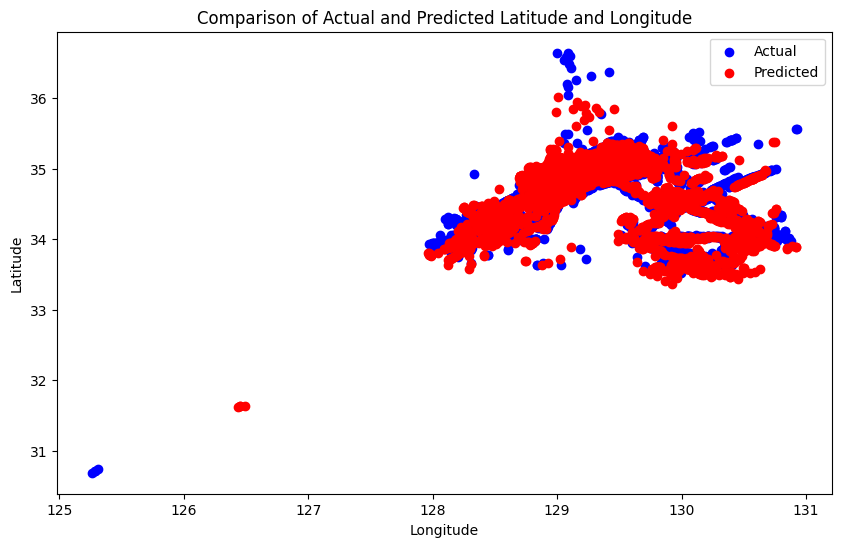

In [17]:
import matplotlib.pyplot as plt

# Get the latitude and longitude values from y_test and y_pred
y_test_lat = y_test['latitude'].values
y_test_lon = y_test['longitude'].values
y_pred_lat = y_pred[:, 0]
y_pred_lon = y_pred[:, 1]

# Create a scatter plot to compare latitude and longitude
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lon, y_test_lat, color='blue', label='Actual')
plt.scatter(y_pred_lon, y_pred_lat, color='red', label='Predicted')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Comparison of Actual and Predicted Latitude and Longitude')
plt.legend()
plt.show()


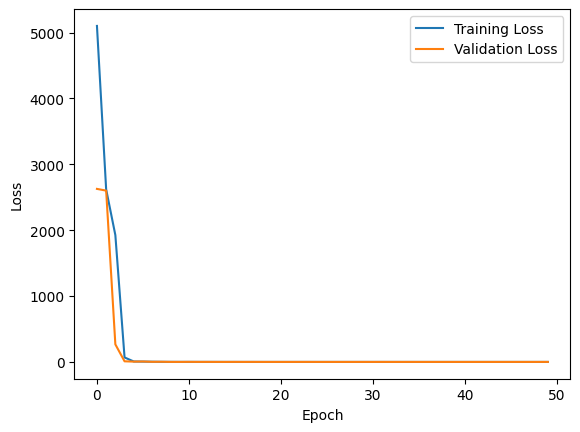

In [19]:
import matplotlib.pyplot as plt


# Plot the validation loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
import pickle

# 모델 저장
with open('linear_regression_model_Lstm_CNN.pkl', 'wb') as file:
    pickle.dump(model, file)
    

# 모델을 불러오기 위해 pickle 파일을 엽니다.
model = pickle.load(open('linear_regression_model_Lstm_CNN.pkl', 'rb'))


# Save the scaler object
with open('scaler_LC.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Load the scaler object
loaded_scaler = pickle.load(open('scaler_LC.pkl', 'rb'))


##### LSTM+CNN 모델

모델 복잡성: LSTM+CNN 모델은 일반적으로 피드포워드 신경망과 같은 단순한 모델보다 더 복잡합니다. 여러 계층과 복잡한 연결이 있어 정방향 통과와 역전파 모두에서 더 많은 계산이 필요합니다. 이렇게 복잡성이 증가하면 교육 시간이 길어질 수 있습니다.

더 긴 시퀀스 길이: LSTM 모델은 입력 요소의 순서가 중요한 순차적 데이터와 함께 작동하도록 설계되었습니다. 데이터의 시퀀스 길이가 긴 경우(예: 많은 시간 단계) LSTM+CNN 모델은 이러한 단계에서 정보를 처리하고 전파해야 하므로 계산 비용과 시간이 많이 소요될 수 있습니다.

많은 수의 매개변수: LSTM+CNN 모델은 종종 단순한 모델에 비해 더 많은 수의 매개변수를 갖습니다. 더 큰 매개변수 공간은 순방향 및 역방향 패스 모두에서 더 많은 계산을 필요로 하므로 훈련 시간이 늘어납니다.

데이터 크기: 데이터 세트가 큰 경우 전체 데이터 세트를 처리하는 데 필요한 반복 횟수가 증가하여 LSTM+CNN 모델을 교육하는 데 시간이 더 오래 걸릴 수 있습니다. 또한 대규모 데이터 세트에는 더 많은 메모리가 필요할 수 있으며, 이는 교육 시간에 영향을 줄 수 있습니다.